In [14]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

#set matplotlib width and height    
# plt.rcParams['figure.figsize'] = [15, 5]

In [15]:
# load csv
def load_csv():
    df = pd.read_csv('data/S_seaice_extent_daily_v3.0.csv', header=0, skiprows=[1], parse_dates=[[0,1,2]], sep=',', engine='python', quotechar='"', skipinitialspace=True)
    df = df.rename(columns={'Year_Month_Day': 'Date'})
    df['doy'] = df['Date'].dt.dayofyear
    df['year'] = df['Date'].dt.year
    df = df.set_index('Date')
    df = df.drop(['Missing', 'Source Data'], axis=1)    
    return df


In [29]:
# show multiple plots
def display(*df, titles = []):
    fig, axs = plt.subplots(len(df), 1, sharex=True, figsize=(12, 4*len(df)))
    if len(df) == 1:
        axs = [axs]
    for i, d in enumerate(df):
        axs[i].plot(d)
        axs[i].set_title(titles[i] if  len(titles)>i else '')
    plt.show()


In [30]:
src_df = load_csv()
src_df

,Extent,doy,year
Date,,,
1978-10-26,17.624,299,1978
1978-10-28,17.803,301,1978
1978-10-30,17.670,303,1978
1978-11-01,17.527,305,1978
1978-11-03,17.486,307,1978
...,...,...,...
2023-06-20,11.357,171,2023
2023-06-21,11.488,172,2023
2023-06-22,11.536,173,2023


In [31]:
df = src_df.copy()

df.interpolate(method='linear', inplace=True, axis=0)


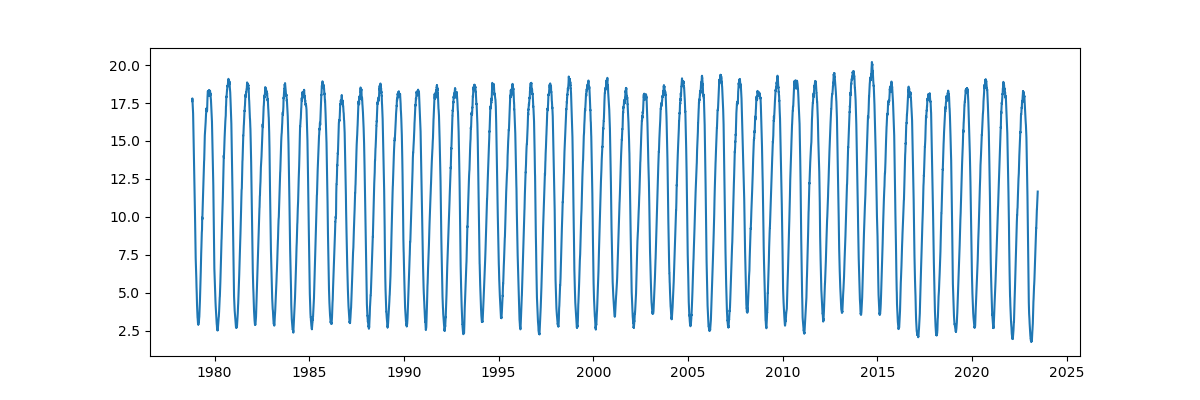

In [36]:
df['Extent'].plot()

display(df['Extent']);

In [37]:
# reproduce Slowing down as an early warning signal for abrupt climate change
# https://www.pnas.org/doi/epdf/10.1073/pnas.0802430105





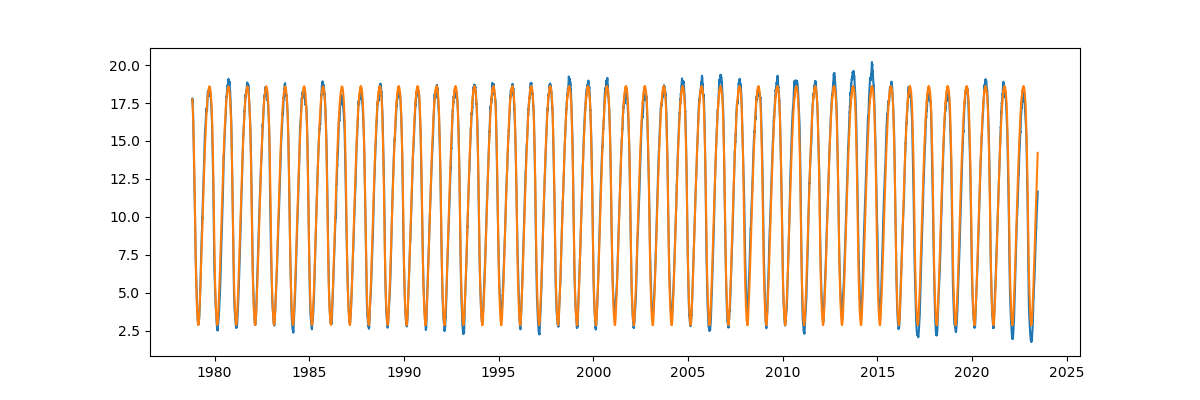

In [38]:
# clim baseline: 81-2010

df_baseline = df.loc[(df['year']>=1981) & (df['year']<=2010)]
df_baseline = df_baseline.reset_index().set_index(['year', 'doy'])
baseline = df_baseline['Extent'].unstack('doy').mean(axis=0).to_frame('baseline')

df_with_bl = df.join(baseline, on='doy')

df_with_bl.dropna(inplace=True)
df_with_bl.interpolate(method='linear', inplace=True, axis=0)

display(df_with_bl[['Extent', 'baseline']]);


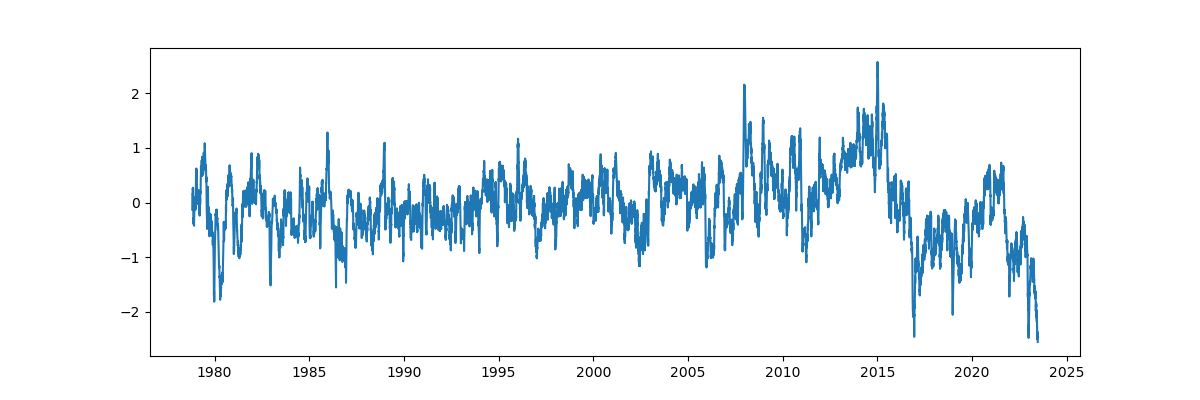

In [39]:


df['ano'] = (df['Extent'] - df_with_bl['baseline'])
df.dropna(inplace=True)
df.interpolate(method='linear', inplace=True, axis=0)

display(df['ano']);

In [40]:
# autoreg lag 1 wit statsmodels

from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(df['ano'], lags=1, trend='c')
model_fit = model.fit()
model_fit.params

/home/mathieu/workspaces/perso/climate/.micromamba/envs/climate/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


const    -0.000426
ano.L1    0.994108
dtype: float64

In [41]:
# autocorrelation with lag 1 is red noise analysis


df['autocorr_10y'] = df['ano'].rolling(window=10*365).apply(lambda x: AutoReg(x, lags=1, trend='c').fit().params[1], raw=True)



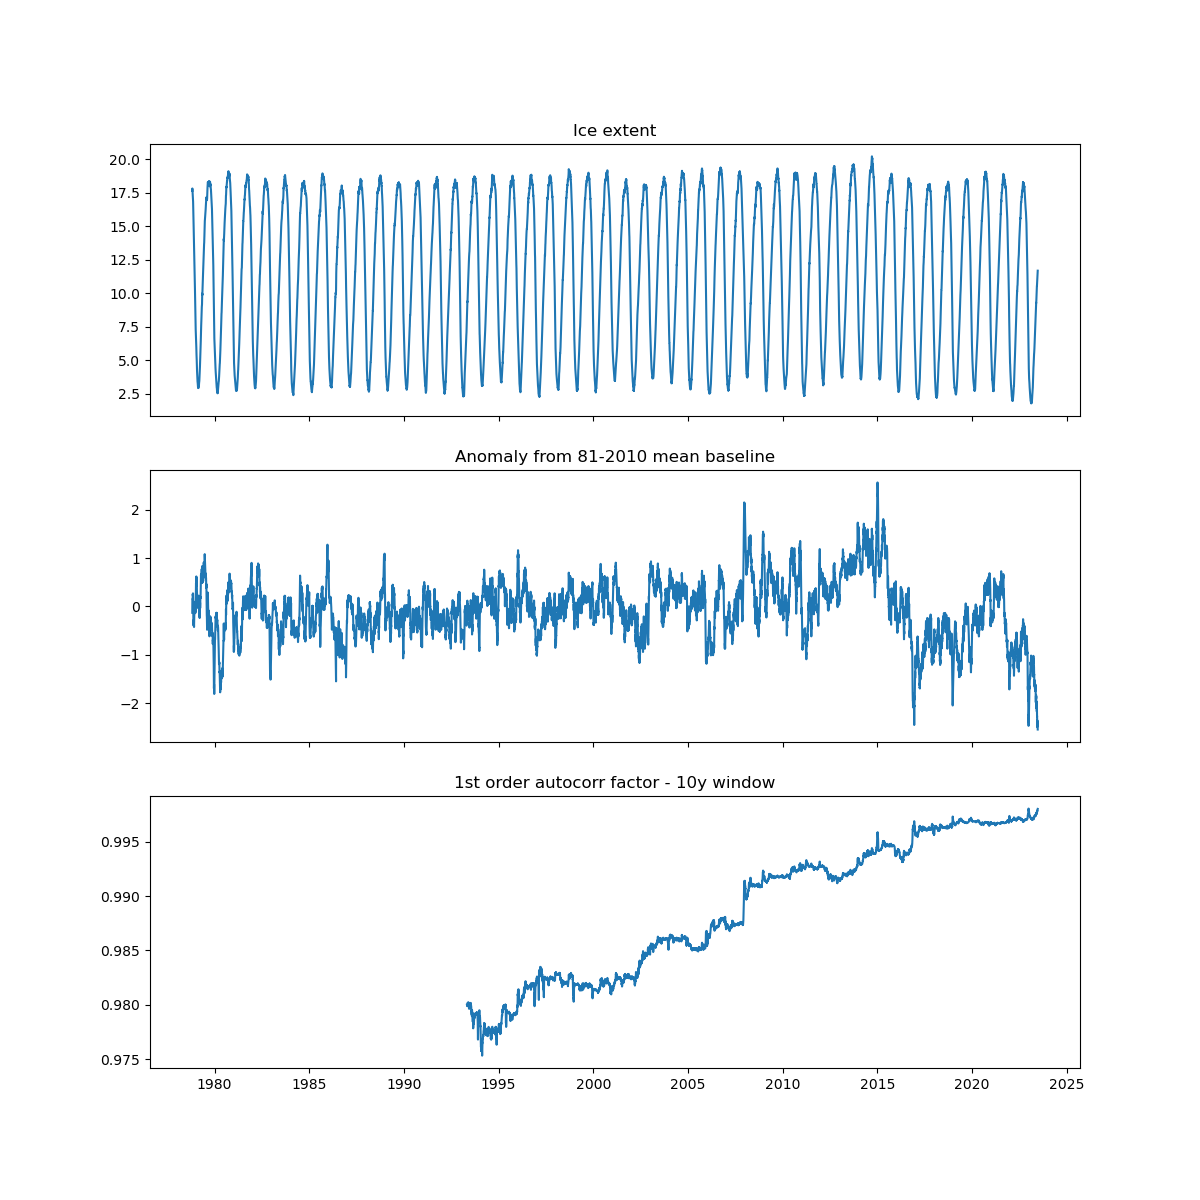

In [44]:
display(df['Extent'], df['ano'], \
    df['autocorr_10y'], \
    titles=['Ice extent', 'Anomaly from 81-2010 mean baseline', '1st order autocorr factor - 10y window']
);
